# <font color=blue> Recommender System for Images on Social Media </font>
**Author:**  Armin Berger

For this project we seek to create a recommender system that can generate user- specific recommendations. More specifically, collaborative filtering models were used to recommend users of the platform Flicker images that match their preferences. The aim was to provide each user with a top 15 selection of images that are likely to match their preference. To showcase the steps taken in creating and training such recommendation models, this report has been broken down into three sections. 

1. Firstly, it will be discussed what data was used to train the models. 
2. Secondly, the two different collaborative filtering models will be introduced and compared. 
3. Lastly, it will be assessed which model performed better as well as the shortcomings and future improvements of each model.

#### Main Idea of a Recommender System

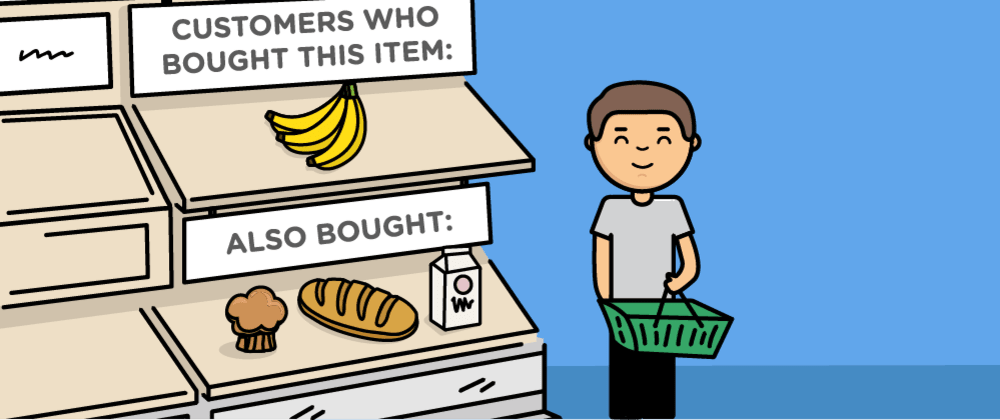

In [2]:
from IPython.display import Image
Image(filename='rec_1.png') 

In [1]:
# install all required packages 

#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn
#!pip install nltk
#!pip install seaborn
#!pip install ggplot
#!pip3 install torch
#!pip3 install implicit
#!pip install Node2Vec


In [2]:
# import all required packages 

import pandas as pd
import numpy as np
import math 
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as matplot
import nltk
import seaborn as sns
import re
import os, sys
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
import implicit # important package
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy.sparse as sparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.svm as svm
import sklearn.cluster as cluster
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import normalized_mutual_info_score
import networkx as nx
from IPython.display import Image
from node2vec import Node2Vec
from sklearn.manifold import TSNE

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Overview

For this project we will provide recommendations to users based on collaborative filltering algorithms.

Firstly, read in the three data sets provided.

In [104]:
# set path of actual current directory and add the location of the data

#data_path =  os.getcwd() +'/data/' # path used for earlier training

data_path = os.getcwd() + '/' # path of actual current directory

data_path

'/Users/arminberger/Desktop/final submission/'

In [4]:
# read in the three data sets provided and save them

# data set to train model
train = pd.read_csv(data_path + 'flickr_train_data.csv')

# data set to validate model
valid = pd.read_csv(data_path + 'flickr_validation_data.csv')

# data set to test model
test = pd.read_csv(data_path + 'flickr_test_data.csv')

# data set that provides additional info on items
item_df = pd.read_csv(data_path + 'flickr_item_fea.csv')

# data set that provides additional info on user connections
links_df = pd.read_csv(data_path + 'flickr_links.csv')

# data set that provides additional info on user preference
user_df = pd.read_csv(data_path + 'flickr_user_fea.csv')

After this we will get a basic overview of the data.

For this task two groups of data sets were provided to create the desired recommender systems. The first group consists of three CSV files labelled ‘flickr_train_data’, ‘flickr_validation_data’, and ‘flickr_test_data’. Both the train and validation data set have three features ‘user_id’, ‘item_id’, and ‘ratings’, where each unique ‘user_id’ is associated with several ‘item_id’ with which the user has either interacted with or not. The interaction of a user with an item is encoded using a rating of 1, whereas 0 represents no user-item interaction. Using this data, we can train our collaborative filtering models since it enables the model to compare user preferences. Based on user preference similarity, it can recommend images similar users interacted with already. The validation data set then enables us to assess and compare the performance of the different model. Lastly, the test data set is used to provide each user with a top 15 selection of images based upon 100 images presented to a user.

#### Train Data

In [5]:
train.head()

,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [6]:
train.columns

Index(['user_id', 'item_id', 'rating'], dtype='object')

#### Valid Data

In [7]:
valid.head()

,user_id,item_id,rating
0,0,20,1
1,0,3260,0
2,0,390,0
3,0,5425,0
4,0,8631,0


In [8]:
valid.columns

Index(['user_id', 'item_id', 'rating'], dtype='object')

#### Test Data

In [9]:
test.head()

,user_id,item_id
0,0,8929
1,0,8906
2,0,8838
3,0,8821
4,0,8756


In [10]:
test.columns

Index(['user_id', 'item_id'], dtype='object')

In [11]:
# get the shape of all three data frame

print(train.shape)
print(valid.shape)
print(test.shape)

(110129, 3)
(346600, 3)
(346600, 2)


In [12]:
# get basic information of all three data frame

print('#### train ####')

print(train.info())

print('')
print('#### valid ####')

print(valid.info())

print('')
print('#### test ####')

print(test.info())

#### train ####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110129 entries, 0 to 110128
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  110129 non-null  int64
 1   item_id  110129 non-null  int64
 2   rating   110129 non-null  int64
dtypes: int64(3)
memory usage: 2.5 MB
None

#### valid ####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346600 entries, 0 to 346599
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  346600 non-null  int64
 1   item_id  346600 non-null  int64
 2   rating   346600 non-null  int64
dtypes: int64(3)
memory usage: 7.9 MB
None

#### test ####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346600 entries, 0 to 346599
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  346600 non-null  int64
 1   item_id  346600 non-null  int64
dtypes: int64(2)


In [13]:
train['rating'].value_counts()

1    110129
Name: rating, dtype: int64

In [14]:
test['user_id'].value_counts()

2047    100
2387    100
2130    100
1874    100
1618    100
       ... 
1446    100
3239    100
1190    100
2983    100
0       100
Name: user_id, Length: 3466, dtype: int64

Check for the number of users 

In [15]:
len(list(set(test['user_id'].to_list())))

3466

The second data set group contained information in another three CSV files labelled ‘flickr_item_fea’, ‘flickr_links’, and ‘flickr_user_fea’. The ‘flickr_item_fea’ contains the pixel information of each image, encoded in 256 columns. The ‘flickr_user_fea’ file contains information on the item a user liked the most. The ‘flickr_links’ provides information on which users are friends with another. Given the underlying assumption that users who are friends on Flicker have similar preferences, one can use this information to provide the recommender system with information on similar users. In this project, the use of both the additional user and image data leads to a substantial recommendation improvement.

#### Item Data

In [16]:
item_df

,Unnamed: 0,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_246,fea_247,fea_248,fea_249,fea_250,fea_251,fea_252,fea_253,fea_254,fea_255
0,0,-1.360416,-0.683295,-0.659030,-1.840172,-1.875868,0.369852,-0.806902,-0.210944,-1.371679,...,-1.287771,-0.003345,-1.017979,-0.849153,-1.564582,-1.167882,-1.138140,-0.459417,-1.342706,-0.491899
1,1,-5.414928,-4.034106,-6.748904,-4.867840,-8.706087,-8.195160,-5.521785,-5.785634,-6.909437,...,-6.531560,-8.419637,-9.145112,-4.200750,-7.780539,-4.257525,-5.879356,-8.006350,-9.809999,-8.942007
2,2,-0.742383,-0.772285,-0.565367,-1.349759,-0.456425,-0.973115,-1.273366,-0.878384,-0.554383,...,-1.065703,-0.614035,-0.517165,-0.655323,-1.019581,-1.706855,-1.084116,-0.940970,-0.905574,-1.151560
3,3,-0.853681,-1.021450,-0.639012,-2.095687,-1.756671,-0.450270,-0.607497,-0.755120,-0.827463,...,-1.223609,-1.181383,-0.928340,-0.841091,-1.477898,-1.802510,-1.177191,-1.632113,-1.980912,-1.298478
4,4,-1.049173,-0.208819,-1.020380,-1.916308,-1.213041,0.404414,-1.085374,-1.219756,-0.854078,...,-1.427951,-0.035228,-0.856884,-1.142188,-1.742321,-0.767455,0.114727,-0.083121,-1.886625,-0.243228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,8999,-0.985023,-0.817845,0.278331,-2.334727,-0.493657,0.193453,-0.091037,-0.052208,-0.734198,...,-0.820217,-0.208619,-0.181342,-1.032526,-0.452872,-0.667447,-1.118185,0.044350,-1.059369,-1.240149
9000,9000,-0.397968,-0.468231,-1.051147,-1.416116,-1.209115,-0.862491,-1.081148,-1.151810,-1.007816,...,-0.927771,-0.692016,-0.930869,-1.314085,-0.779665,-1.113890,-0.722510,-1.455863,-1.520061,-0.461387
9001,9001,-0.387659,-1.241516,-1.118529,-2.025316,-2.436767,-0.936830,-2.213711,-1.324245,-2.002571,...,-2.409009,-1.352146,-1.068698,-1.768486,-1.604628,-0.842151,-1.341742,-2.386787,-2.120183,-1.107710
9002,9002,-0.973734,-0.804314,-0.733195,-0.608296,-1.129770,-1.349558,-0.599012,-0.946626,-0.947507,...,-1.792138,0.024926,-0.864332,-0.881979,-0.719055,-0.211492,-0.742412,-0.311049,0.139330,-0.453119


In [17]:
item_df = item_df.rename(columns={'Unnamed: 0': 'item_id'})

In [18]:
item_df

,item_id,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_246,fea_247,fea_248,fea_249,fea_250,fea_251,fea_252,fea_253,fea_254,fea_255
0,0,-1.360416,-0.683295,-0.659030,-1.840172,-1.875868,0.369852,-0.806902,-0.210944,-1.371679,...,-1.287771,-0.003345,-1.017979,-0.849153,-1.564582,-1.167882,-1.138140,-0.459417,-1.342706,-0.491899
1,1,-5.414928,-4.034106,-6.748904,-4.867840,-8.706087,-8.195160,-5.521785,-5.785634,-6.909437,...,-6.531560,-8.419637,-9.145112,-4.200750,-7.780539,-4.257525,-5.879356,-8.006350,-9.809999,-8.942007
2,2,-0.742383,-0.772285,-0.565367,-1.349759,-0.456425,-0.973115,-1.273366,-0.878384,-0.554383,...,-1.065703,-0.614035,-0.517165,-0.655323,-1.019581,-1.706855,-1.084116,-0.940970,-0.905574,-1.151560
3,3,-0.853681,-1.021450,-0.639012,-2.095687,-1.756671,-0.450270,-0.607497,-0.755120,-0.827463,...,-1.223609,-1.181383,-0.928340,-0.841091,-1.477898,-1.802510,-1.177191,-1.632113,-1.980912,-1.298478
4,4,-1.049173,-0.208819,-1.020380,-1.916308,-1.213041,0.404414,-1.085374,-1.219756,-0.854078,...,-1.427951,-0.035228,-0.856884,-1.142188,-1.742321,-0.767455,0.114727,-0.083121,-1.886625,-0.243228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,8999,-0.985023,-0.817845,0.278331,-2.334727,-0.493657,0.193453,-0.091037,-0.052208,-0.734198,...,-0.820217,-0.208619,-0.181342,-1.032526,-0.452872,-0.667447,-1.118185,0.044350,-1.059369,-1.240149
9000,9000,-0.397968,-0.468231,-1.051147,-1.416116,-1.209115,-0.862491,-1.081148,-1.151810,-1.007816,...,-0.927771,-0.692016,-0.930869,-1.314085,-0.779665,-1.113890,-0.722510,-1.455863,-1.520061,-0.461387
9001,9001,-0.387659,-1.241516,-1.118529,-2.025316,-2.436767,-0.936830,-2.213711,-1.324245,-2.002571,...,-2.409009,-1.352146,-1.068698,-1.768486,-1.604628,-0.842151,-1.341742,-2.386787,-2.120183,-1.107710
9002,9002,-0.973734,-0.804314,-0.733195,-0.608296,-1.129770,-1.349558,-0.599012,-0.946626,-0.947507,...,-1.792138,0.024926,-0.864332,-0.881979,-0.719055,-0.211492,-0.742412,-0.311049,0.139330,-0.453119


#### Link Data

In [19]:
links_df

,src,des,weight
0,0,1431,1
1,0,955,1
2,0,1824,1
3,0,70,1
4,0,592,1
...,...,...,...
63989,3465,2966,1
63990,3465,1872,1
63991,3465,733,1
63992,3465,507,1


#### User Data

In [20]:
user_df

,Unnamed: 0,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_246,fea_247,fea_248,fea_249,fea_250,fea_251,fea_252,fea_253,fea_254,fea_255
0,0,-1.238114,-1.020155,-1.370791,-1.892076,-1.615505,-1.056106,-1.260189,-1.537514,-1.279543,...,-1.639152,-1.351084,-1.526210,-1.441551,-1.567562,-1.363613,-1.133677,-1.448653,-1.912987,-1.220462
1,1,-1.142714,-1.012310,-1.109844,-1.806807,-1.533666,-0.894846,-1.360289,-1.159866,-1.184760,...,-1.471417,-1.028792,-1.397979,-1.304754,-1.630009,-1.318048,-1.080598,-1.251735,-1.813930,-0.975978
2,2,-1.698521,-1.605196,-1.328976,-1.492204,-1.541542,-1.155632,-1.297039,-1.485625,-1.348223,...,-1.529016,-1.372415,-1.769800,-1.414428,-1.550462,-1.249593,-1.284915,-1.446422,-1.686583,-1.145916
3,3,-1.328761,-1.267363,-1.243220,-1.721551,-1.182082,-1.320123,-1.115170,-1.122703,-1.140961,...,-1.441997,-0.956042,-1.570591,-1.238835,-1.489867,-1.320204,-1.202990,-1.322884,-1.580290,-0.931394
4,4,-1.132466,-1.026957,-1.019664,-1.649181,-1.382753,-0.776261,-1.221357,-1.061034,-1.041313,...,-1.307160,-0.940088,-1.313026,-1.308773,-1.455208,-1.056440,-0.950118,-1.029165,-1.593675,-0.886145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461,3461,-0.985914,-0.909812,-0.927938,-1.622281,-0.839910,-0.722871,-0.962304,-0.899670,-0.855909,...,-0.933843,-0.674939,-1.038403,-1.278852,-1.048469,-0.666743,-0.739613,-0.552098,-1.398171,-0.618760
3462,3462,-1.528833,-1.317308,-1.240643,-1.674515,-1.569974,-1.703787,-1.411700,-1.490773,-1.029417,...,-1.428501,-1.387665,-1.434043,-1.522813,-1.708464,-1.446735,-1.682596,-1.458979,-1.648339,-1.299726
3463,3463,-1.720539,-1.573586,-1.674203,-1.694080,-1.989523,-1.696773,-1.577269,-1.871449,-1.555799,...,-1.949060,-1.380057,-1.958907,-1.681401,-1.988764,-1.625365,-1.604610,-1.557434,-1.909479,-1.597918
3464,3464,-1.138993,-0.935112,-1.003635,-1.717942,-1.402207,-0.945415,-1.292941,-1.198142,-1.123732,...,-1.471624,-1.142418,-1.364630,-1.361708,-1.514338,-1.173796,-0.959845,-1.006382,-1.710620,-1.011344


In [21]:
user_df = user_df.rename(columns={'Unnamed: 0': 'user_id'})

In [22]:
user_df

,user_id,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_246,fea_247,fea_248,fea_249,fea_250,fea_251,fea_252,fea_253,fea_254,fea_255
0,0,-1.238114,-1.020155,-1.370791,-1.892076,-1.615505,-1.056106,-1.260189,-1.537514,-1.279543,...,-1.639152,-1.351084,-1.526210,-1.441551,-1.567562,-1.363613,-1.133677,-1.448653,-1.912987,-1.220462
1,1,-1.142714,-1.012310,-1.109844,-1.806807,-1.533666,-0.894846,-1.360289,-1.159866,-1.184760,...,-1.471417,-1.028792,-1.397979,-1.304754,-1.630009,-1.318048,-1.080598,-1.251735,-1.813930,-0.975978
2,2,-1.698521,-1.605196,-1.328976,-1.492204,-1.541542,-1.155632,-1.297039,-1.485625,-1.348223,...,-1.529016,-1.372415,-1.769800,-1.414428,-1.550462,-1.249593,-1.284915,-1.446422,-1.686583,-1.145916
3,3,-1.328761,-1.267363,-1.243220,-1.721551,-1.182082,-1.320123,-1.115170,-1.122703,-1.140961,...,-1.441997,-0.956042,-1.570591,-1.238835,-1.489867,-1.320204,-1.202990,-1.322884,-1.580290,-0.931394
4,4,-1.132466,-1.026957,-1.019664,-1.649181,-1.382753,-0.776261,-1.221357,-1.061034,-1.041313,...,-1.307160,-0.940088,-1.313026,-1.308773,-1.455208,-1.056440,-0.950118,-1.029165,-1.593675,-0.886145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461,3461,-0.985914,-0.909812,-0.927938,-1.622281,-0.839910,-0.722871,-0.962304,-0.899670,-0.855909,...,-0.933843,-0.674939,-1.038403,-1.278852,-1.048469,-0.666743,-0.739613,-0.552098,-1.398171,-0.618760
3462,3462,-1.528833,-1.317308,-1.240643,-1.674515,-1.569974,-1.703787,-1.411700,-1.490773,-1.029417,...,-1.428501,-1.387665,-1.434043,-1.522813,-1.708464,-1.446735,-1.682596,-1.458979,-1.648339,-1.299726
3463,3463,-1.720539,-1.573586,-1.674203,-1.694080,-1.989523,-1.696773,-1.577269,-1.871449,-1.555799,...,-1.949060,-1.380057,-1.958907,-1.681401,-1.988764,-1.625365,-1.604610,-1.557434,-1.909479,-1.597918
3464,3464,-1.138993,-0.935112,-1.003635,-1.717942,-1.402207,-0.945415,-1.292941,-1.198142,-1.123732,...,-1.471624,-1.142418,-1.364630,-1.361708,-1.514338,-1.173796,-0.959845,-1.006382,-1.710620,-1.011344


## 1.1 - Create and Adjust Ratings in Test Data

The test data set currently doesn't have a rating assoicated with each user / item interaction. Ratings for user / item interactions are viatal however for providing accurate predictions. Thus we have taken three main steps to create and finetune ratings for each user.

1. Add a rating column to the test data set and give a default traing of 0
2. For each user / item interaction check whether the user has already interacted with an image before (check training set)
3. Using the optional user and item data to calculate the cosine similarity of each user / item interaction, then add that cosine similarity to the existing rating


We will apply the same set of steps to the ratings of the training data in order train our collaborative filtering model on more 'informative' data.

These three steps will enable our collaborative filtering model to produce more accurate predictions. 

Firtsly, since the test data doesn't have a rating column yet we will add a rating column with the default value of 0.

In [23]:
# create rating column, default value 0
test['rating'] = 0

Secondly, in the next step we will combine the train and test data to check if users have already interacted with the item. In the case that useres already interacted with an item, we set the rating to 1. Later on this will enable us to remove these items as potential recommendations.

In [24]:
# create copy of train data set
train_new = train

# merge the train and test data into one large dataframe
train_new = train_new.append(test, ignore_index=True)

# sort the dataframe by user_ids
train_new = train_new.sort_values(by = 'user_id', ignore_index=True)

train_new.shape

(456729, 3)

Now we will isolate all the duplicate entries. A duplicate entry indicates that the user in the test set would have already interated with an item. Thus we will set the rating to 1 in the test data set.

In [25]:
# save all duplicate entries in a data
duplicate = train_new[train_new.duplicated(['user_id', 'item_id'])]

# turn the dataframe into a dict for faster data processing later
dup_dict = duplicate.to_dict('split')

# create list to save all duplicates in
duplicate_list = []

# iterate through duplicates in dict dup_dict
for i in range(0, len(dup_dict['data'])):
    
    # append each entry as a tuple to duplicate_list
    duplicate_list.append((dup_dict['data'][i][0],dup_dict['data'][i][1]))
    
# turn list into set to keep only unqiue duplicates 
duplicate_set = set(duplicate_list)

# check numnber of final unique duplicates
len(duplicate_set)

1878

Now we will set the rating of all already seen items to 1 in the test data set.

In [26]:
# function that helps us identify items in the test set users have aleady interacted with
# since users would have already interacted with the item it won't be recommended again
def set_rate(test_user_id, test_item_id):
    
    # create a default rating of 0
    test_rate = 0
    
    # create user and item id tuple 
    data = (test_user_id, test_item_id)
    
    # check whether user and item id tuple is contained in duplicate set
    if data in duplicate_set:
        
        # if yes, set rating to 1
        test_rate = 1
    
    # return the new rating
    return test_rate

In [27]:
# apply the function set_rate() to the whole test dataset
test['rating'] = test.apply(lambda row: set_rate(row['user_id'], row['item_id']),axis=1)

In [28]:
# check how many test data entries had their rating set to 1
test.loc[test['rating'] == 1]

,user_id,item_id,rating
110,1,8131,1
111,1,8131,1
219,2,6950,1
220,2,6950,1
440,4,4999,1
...,...,...,...
345838,3458,4645,1
345921,3459,6969,1
345922,3459,6969,1
346451,3464,4448,1


Now all items a user has alredy interated with in the test set has a rating of 1 and will thus be excluded when creating recommendations for useres.

Thirdly, we will use the image information stored in the optional user and item dataframes to calculate the cosine similarity of each user / item interaction. Then we will add that cosine similarity to the existing rating. This final step will significantly enhance our models ability to produce more accurate predictions. 

In [29]:
# function that helps us calculate the cosine similarity of each user / item interaction
# takes user_id, item_id, and rating as inputs and returns the adjusted rating
def cal_item_similarity(test_user_id, test_item_id, rating):
    
    ## Get user data
    
    # given the test_user_id retreive the user specifc item preference 
    # this is given in the form of 256 pixel data points each in a seperate column of a dataframe
    test_user_id_pref = user_df.loc[user_df['user_id'] == test_user_id]
    
    # subselect the pixel data out of the dataframe
    test_user_id_pref = test_user_id_pref.iloc[0,1:]
    
    # turn dataframe row into a numpy array
    test_user_id_pref = test_user_id_pref.to_numpy()
    
    # reshape the numpy array to enable calculation of the cosine similarity
    test_user_id_pref = test_user_id_pref.reshape(1, -1)

    
    ## Get item data
    
    # given the test_item_id retreive the characteristics of each image
    # this is given in the form of 256 pixel data points each in a seperate column of a dataframe
    test_item_id_pref = item_df.loc[item_df['item_id'] == test_item_id]
    
    # subselect the pixel data out of the dataframe
    test_item_id_pref = test_item_id_pref.iloc[0,1:]
    
    # turn dataframe row into a numpy array
    test_item_id_pref = test_item_id_pref.to_numpy()
    
    # reshape the numpy array to enable calculation of the cosine similarity
    test_item_id_pref = test_item_id_pref.reshape(1, -1)
    
    # calculate the cosine similarity of each user / item interaction
    item_sim = cosine_similarity(test_user_id_pref, test_item_id_pref)
    
    # add cosine similarity to existing rating
    item_sim = float(item_sim) + rating
    
    # return final rating
    return item_sim

In [30]:
# apply the function set_rate() to the whole test dataset
test['rating'] = test.apply(lambda row: cal_item_similarity(row['user_id'], row['item_id'], row['rating']),axis=1)

After finetuning the ratings we can start creating the top 15 recommendations for each user.

In [31]:
# apply the function set_rate() to the whole test dataset
train['rating'] = train.apply(lambda row: cal_item_similarity(row['user_id'], row['item_id'], row['rating']),axis=1)


## 1.2 - Transform Inputs and Train Model

In the second step, we will transform the model inputs into sparse matricese. Then we will train the recommender model on that input. For this project we will compare two models.

Firstly, the Alternating Least Squares Model using the implicit package. Secondly, the Matrix Factorisation Model.

#### Model 1 - Alternating Least Squares (ALS)

In [32]:
# convert to sparse matrix
sparse_content_person = sparse.csr_matrix((train['rating'].astype(float), (train['item_id'], train['user_id'])))
sparse_person_content = sparse.csr_matrix((train['rating'].astype(float), (train['user_id'], train['item_id'])))

Fitting the model using the implicit library. Since, I was not able to apply traditional cross validation approaches to the implicit library I applied a "brute force" method and tried out all values from 1 to 80 for both hyperparatmeters alpha and factors.
The best performance was achieved with aplpha = 72 and factors = 7.

In [33]:
# the rate in which we'll increase our confidence in a preference with more interactions
alpha = 72

# set the data used to train the model
data = (sparse_content_person * alpha).astype('double')

In [34]:
# set random seed for the model so the output is reproducable 
random.seed(10)

# set the model parameters
model_01 = implicit.als.AlternatingLeastSquares(factors=7, regularization=0.1, iterations=50)

# fit the model
model_01.fit(data)

In [35]:
# create methode used for making user specific top 15 item recommendations
def recommend(user_id, sparse_person_content, person_vecs, content_vecs, num_contents=15):
    
    # Get the interaction scores from the sparse person content matrix
    # idea: for each user we get all item interactions (like or does not like)
    person_interactions = sparse_person_content[user_id,:].toarray()
    
    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1
    
    # Make articles already interacted with equal to zero
    person_interactions[person_interactions > 2] = 0
    
    # Get dot product of person vector and all content vectors
    # this gives me the predcicted rating of all itsm for one user
    rec_vector = person_vecs[user_id,:].dot(content_vecs.T).toarray()
    
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    
    # Content already interacted have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    
    # Sort the indices of the content into order of best recommendations
    item_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    # Start empty list to store item_id and scores
    users = []
    item_id = []

    for idx in item_idx:
        
        # Append item_id and scores to the list
        item_id.append(int(train.item_id.loc[train.item_id == idx].iloc[0]))
        
        users.append(int(user_id))

    recommendations = (users, item_id)
    
    return recommendations


#### Model 2 - Matrix Factorisation

In [36]:
# define the Matrix Factorisation class
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        
    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1) 

In [37]:
# set the number of user
num_users = len(train.user_id.unique())

# set the number of items
num_items = len(train.item_id.unique())

In [38]:
# set the parameters of the Matrix Factorisation model
model_02 = MF(num_users, num_items, emb_size=257)

In [39]:
# define the model training function
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    
    for i in range(epochs):
        users = torch.LongTensor(train.user_id.values) # .cuda()
        items = torch.LongTensor(train.item_id.values) #.cuda()
        ratings = torch.FloatTensor(train.rating.values) #.cuda()
        
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
            
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item()) 
    test_loss(model, unsqueeze)

In [40]:
# define the model testing function
def test_loss(model, unsqueeze=False):
    model.eval()
    
    users = torch.LongTensor(valid.user_id.values) #.cuda()
    items = torch.LongTensor(valid.item_id.values) #.cuda()
    ratings = torch.FloatTensor(valid.rating.values) #.cuda()
    
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
        
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())

In [41]:
# define the model prediction function
def test_predict(model, data, unsqueeze=False):
    model.eval()
    
    with torch.no_grad():
        
        users = torch.LongTensor(data.user_id.values) # .cuda()
        items = torch.LongTensor(data.item_id.values) #.cuda()
        ratings = torch.FloatTensor(data.rating.values) #.cuda()
        
        prediction = model(users, items)
        
        return prediction
    

In [42]:
# train the matrix factorisation
train_epocs(model_02, epochs=10, lr=0.01)

2.9963433742523193
2.487689971923828
1.8839313983917236
1.2458769083023071
0.6527143716812134
0.20399388670921326
0.008414337411522865
0.12350903451442719
0.4210858643054962
0.6223400235176086
test loss 7.074 


Now we have two trained models to use.

## 1.3 - Compare Model Performance using DCG Score on Validation  Data
In the following, we will test which of the above two created models performs better at providing accurate top 15 recommendations for any given user. Before that we will provide a broad overview and comparison of the models avialable for recommender systems.

#### Overview Recommender Systems

Broadly speaking there are three types of recommender systems. These are Content, Collaborative Filtering, and Latent Factor-based recommender systems. For this task, we deployed a collaborative filtering and a latent factor-based recommender system. This model choice is largely due to the fact that we have access to reliable historic data on previous user- item interactions and that given the availability of such data, these models tend to produce accurate predictions. More specifically the two models used are Matrix Factorisation, a common factor-based model, and Alternating Least Squares (ALS), a common collaborative filtering model. For each model, we will describe the creation process as well as their performance and weakness. Model performance, in this case, will be calculated using the Discounted Cumulative Gain (DCG). This approach discounts recommendations based on how far up the rank a correct recommendation is.

#### Matrix Factorisation
The Matrix Factorisation model is built on the concept that both users and items can be represented in a low dimensional space. In this space, their properties can be described through their position in the space and thus we can recommend items to users based on their position. This position or location of users and items is expressed using vectors. The basic idea is that the rating that user A has for item B can be determined by calculating the dot product of their locations. Given that dot product, we can assess how much a user will like an item. This type of model attained widespread popularity through the 2006 Netflix Price Recommender System Competition which it won.

For this task, we implement a basic Matrix Factorisation model which was trained using the ‘flickr_train_data’. To enhance the accuracy of predictions we added more nuance to the ratings of the data the model was trained and tested on. The current ratings only had 0 and 1 values. Therefore, to add more nuance to these ratings we applied the content recommendation-based strategy of calculating the cosine similarity between users and items. A large cosine similarity will lead to items being prioritized when making user recommendations. Despite these adjustments and the large data set to train the model on, we only achieved a DCG score of 273.82, a substantially worse result than the Alternating Least Squares model.

To improve the model’s performance, one could tune the hyperparameters of the model, such as learning rate or training epochs. This was, however, not done due to the large computational complexity in comparison to the marginal performance gain from an underperforming model. Given this poor performance, the model was not chosen for the final user recommendations submitted to Kaggle.

#### Alternating Least Squares
The Alternating Least Squares model is built on the concept of discovering and using patterns that involve the interactions of multiple actors. The basic idea is that if actor A and actor B have interacted and liked similar items, in this case, images. The model will recommend images to actor A that they haven’t seen but which actor B and similar actors have seen and liked. Reversely, images that were seen and liked by actor A and similar actors will be recommended to actor B. As mentioned earlier providing users with recommendations using this type of model is only possible since we have a large data set of past user-item interactions which enable the identification of such patterns between actors.
For this task, we implemented the Alternating Least Squares model using the implicit package. The model built on this package only required the sparse matrix input of the user and item data. Given this input, the model determines patterns between users. To enhance model performance, I tuned the model's hyperparameters alpha and factors. This was done by applying a grid search method, that tried out all values from 1 to 80 for both hyperparameters alpha and factors. The best performance was achieved with alpha = 72 and factors = 7. After training and tuning the model, we created a recommender method that would take a ‘user_id’ and a set of items as input and based on that would return the top 15 recommended items for each ‘user_id’. Since the testing data has no rating column, we have added a rating column with the default value of 0. We then checked if a user had already interacted with an item and set the rating to 1.
Like the process used for the Matrix Factorisation model, for the purpose of enhancing the accuracy of these predictions we added more nuance to the ratings of the data the model was trained and tested on. The current ratings only had 0 and 1 values. To add more nuance to these ratings we applied the content recommendation-based strategy of calculating the cosine similarity between users and items. A large cosine similarity will then be indicative of an item matching user preferences. Thus, it will be prioritized when making user recommendations. Moreover, we ensured that duplicate and already interacted with item_ids from the training data set had their ratings set to one, leading them to be ignored in the recommendation process. 

#### DCG Performance Model 1 - Alternating Least Squares

In [43]:
# save new version of the validation data set
valid_new = valid 

In [44]:
# make top 15 recommendations for valid data set

# convert the valid data to sparse matrix
sparse_person_content_01 = sparse.csr_matrix((valid['rating'].astype(float), (valid['user_id'], valid['item_id'])))

# get the trained person vectors, we convert them to csr matrices
person_vecs_01 = sparse.csr_matrix(model_01.user_factors)

# get the trained content vectors, we convert them to csr matrices
content_vecs_01 = sparse.csr_matrix(model_01.item_factors)

# create a list of all user_ids
valid_users = list(set(valid['user_id']))

# create a dataframe to save the top 15 recommendations for each user
valid_new_01 = pd.DataFrame({'user_id' : [], 'item_id' : []}, dtype=int)


# calculate the recommendations for all users in the data se
for user in valid_users:
    
    # using the recommend() methode create the top 15 recommendations for all users
    recommendations = recommend(user, sparse_person_content_01, person_vecs_01, content_vecs_01)
    
    # for each of the 15 recommendations append them to valid_new_01
    for i in range(0, len(recommendations[0])):
        
        # append each recommendation
        valid_new_01 = valid_new_01.append({'user_id' : int(recommendations[0][i]) , 'item_id' : int(recommendations[1][i])}, ignore_index=True)

In [45]:
# get DCG score for AIC

# set dcg score
dcg_score = 0

# iterate through each user_id in valid_new_01
for i in range(0, max(valid_new_01['user_id'])):
    
    # for each user id get the items given in the validation dataset
    top_item = valid.loc[valid['user_id'] == i]
    
    # extract the one item that each user liked the most
    top_item = top_item.loc[top_item['rating'] == 1]
    
    # turn the top 15 recommendation dataframe into a list
    top_item = top_item[['user_id', 'item_id']].values.tolist()
    
    # save the top 15 user items as tuple
    user_item = (top_item[0][0],top_item[0][1])
    
    # check the location of the top item that each user liked the most
    per_user = valid_new_01.loc[valid_new_01['user_id'] == i]
    
    # save it in list format
    per_user = per_user.values.tolist()
    
    # iterate through each element in that list
    for x in range(0,len(per_user)):
        
        # when the top item that each user liked the most is found 
        if (user_item[0], user_item[1]) == (per_user[x][0],per_user[x][1]):
            
            # calculate the dcg score add it to dcg_score
            dcg_score += (1/math.log(2 + x))
            

In [46]:
# check model dcg score
dcg_score

3853.046627903283

#### DCG Performance Model 2 - Matrix Factorization

In [47]:
# save new version of the validation dataset
valid_new = valid 

# add a new column to the validation dataset that saves the prediction made by the Matrix Factorization model
valid_new['predictions_mf'] = test_predict(model_02, valid_new)

# sort the data frame by user_id and the recommendation score, top score is first
valid_new = valid_new.sort_values(['user_id', 'predictions_mf'], ascending=False)

# reset the dataframes index
valid_new = valid_new.reset_index(drop = True)

In [48]:
# create a dataframe to save the top 15 recommendations for each user
valid_new_02 = pd.DataFrame({'user_id' : [], 'item_id' : [], 'rating' : []}, dtype=int)

# iterate through each user id 
for i in range(0, max(valid_new['user_id'])):
    
    # for each user_id retreive all matching item entries in the dataframe valid_new
    per_user = valid_new.loc[valid_new['user_id'] == i]
    
    # only keep the top 15 items
    per_user = per_user.iloc[0:15,]
    
    # set the format of the inforamtion that will be appended
    per_user = per_user[['user_id', 'item_id', 'rating']]
    
    # append the top top 15 items and their ratings per user
    valid_new_02 = valid_new_02.append(per_user, ignore_index=True)

In [49]:
# calculate the dcg for MF model

# set dcg score
dcg_score = 0

# iteratate through each user id in dataframe valid_new_02
for i in range(0, max(valid_new_02['user_id'])):

    # for each user_id extract all entires
    per_user = valid_new_02.loc[valid_new_02['user_id'] == i]
    
    # if non of the 15 recommendations made by the model contain the top item that each user liked the most
    if set(per_user['rating']) == {0}:
        
        # no increase in the dcg score
        dcg_score += 0
    
    # if one of the 15 recommendations made by the model contain the top item that each user liked the most
    elif set(per_user['rating']) != {0}:
        
        # get the top 15 recommendations made by the model
        rate = per_user['rating'].reset_index(drop = True)
        
        # determine the location of the top item that each user liked the most
        x = rate.loc[rate == 1]
        
        # turn that location, a number between 0 and 14 into an integer
        x = int(x.index[0])
        
        # calculat the dcg score of each recommendation for each user and add it to dcg_score
        dcg_score += (1/math.log(2 + x))
              

In [50]:
# check model dcg score
dcg_score

267.8394308364356

After assessing the performance of both models we observed that the ALS model performed better than the Matrix Factorization Model, based on the DCG Score calculated for both. Thus, we will use the ALS model to provide recommendations based on the test data.

## 1.4 - Recommend Top 15 Images to Users in Test Data
In the following, we will return the top 15 recommendations chosen based on the person / content vectors for contents never interacted with for any given user. 

For Model 1 the flow of the function is as follows:

-	For each user we extract the interactions score between users and items using the sparse person content matrix
-	Since a higher interaction score leads to the model recommending an item to a user, we add 1 to all interaction scores, thus items which user have not interacted with have a higher likelihood of getting recommended
-	All items that users already interacted with are set to 0 since we do not want to recommend already seen items to users 
-	To provide the user with recommendations we then take the dot product of person vector and content vectors
-	This recommendation is then scaled from 0 to 1 to standardize the recommendation amongst items
-	To give users the best recommendations we sort the items in descending order
-	We extract only the top 15 recommended items and save their item id in combination with the matching user-id


This recommender method can be applied to both the validation ad testing data. When testing this model approach on the validation data set it retuned a DCG score of 3,891.28, a substantially better result than the Matrix Factorisation model. Given the good performance, this model was chosen for the final user recommendations submitted to Kaggle.

Despite the great performance of this Alternating Least Squares model on our data, collaborative filtering models have two main downsides. Firstly, we need a sufficiently large user base to provide relevant recommendations, this is also referred to as the ‘cold start’ problem. Secondly, items that have not been viewed very often are unlikely to be picked up, thus the model tends to favour popular mainstream items that have been viewed by many. Regarding the first issue, we were provided with a large historic data set of user-item interactions which mitigate the cold start problem. The second issue, however, is not mitigated. The data set used contains over 9,000 items which could likely lead to a neglect of less commonly interacted with items.

In [51]:
# make top 15 recommendations for test data set


# convert the test data to sparse matrix
sparse_person_content = sparse.csr_matrix((test['rating'].astype(float), (test['user_id'], test['item_id'])))

# Get the trained person vectors, convert them to csr matrices
person_vecs = sparse.csr_matrix(model_01.user_factors)

# Get the trained content vectors, convert them to csr matrices
content_vecs = sparse.csr_matrix(model_01.item_factors)

# create list of all user_ids in the test data
test_users = list(set(test['user_id']))

# create a data frame to save the top 15 recommendations per user
solution_data = pd.DataFrame({'user_id' : [], 'item_id' : []}, dtype=int)    

# calculate the recommendations for all users in the data se
for user in test_users:
    
    # get the top 15 recommendations
    recommendations = recommend(user, sparse_person_content, person_vecs, content_vecs)
    
    # for each recommendation appendit to solution_data
    for i in range(0, len(recommendations[0])):
    
        solution_data = solution_data.append({'user_id' : int(recommendations[0][i]) ,\
                                              'item_id' : int(recommendations[1][i])}, ignore_index=True)

    

In [52]:
# example: for user_id 5 we have exactly the top 15 recomendations
solution_data.loc[solution_data["user_id"] == 0]

,user_id,item_id
0,0,1267
1,0,7930
2,0,7091
3,0,7568
4,0,7795
5,0,3144
6,0,1859
7,0,7128
8,0,2607
9,0,8275


## 1.4 - Write Top 15 Images per Users to CSV File

We output the final results of the best model in a csv file.

In [53]:
# finally we write the edited dataframe to a csv file 
solution_data.to_csv('26255367_output.csv', index = False)